# Channel Charting-based Channel Prediction

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import scipy.spatial

## Training and Prediction Set

In [2]:
### training set ###
# frequency domain CSI
csi_freq_domain = np.load('dataset/csi_freq_domain_train.npy')
csi_freq_domain = csi_freq_domain.reshape(csi_freq_domain.shape[0],csi_freq_domain.shape[1],csi_freq_domain.shape[2]*csi_freq_domain.shape[3],csi_freq_domain.shape[4])

# channel chart positions
channel_chart_positions = np.load('results/channel_chart_positions_train.npy')

### prediction set ###
# frequency domain CSI
csi_freq_domain_pred = np.load('dataset/csi_freq_domain_pred.npy')
csi_freq_domain_pred = csi_freq_domain_pred.reshape(csi_freq_domain_pred.shape[0],csi_freq_domain_pred.shape[1],csi_freq_domain_pred.shape[2]*csi_freq_domain_pred.shape[3],csi_freq_domain_pred.shape[4])

# channel chart positions
channel_chart_positions_pred = np.load('results/channel_chart_positions_pred.npy')

# timestamps
timestamps_pred = np.load('dataset/timestamps_pred.npy')

# indices of samples used for prediction
prediction_indices = np.load('dataset/prediction_indices.npy')

## Predict Channel Chart Positions

In [3]:
# set memory size and prediction horizon
k = 25 # l-k, ..., l
p = 15 # l + p

# emphasize most recent samples more
prediction_weights = np.sqrt(np.arange(1,k+1))
prediction_weights = prediction_weights/np.linalg.norm(prediction_weights)

In [4]:
true_cc_positions_pred = []
predicted_cc_positions_pred = []

true_csi_freq_domain_pred = [] # Ground Truth
outdated_csi_freq_domain_pred = [] # Baseline CSI for Channel Prediction

for i in range(prediction_indices.shape[0]):
    # index to predict l
    l = prediction_indices[i,-1]
    # true cc position at l
    true_cc_positions_pred.append(channel_chart_positions_pred[l])
    # previous cc positions at l-p,l-p-1,...,l-p-k+1
    if p == 0:
        previous_indices = prediction_indices[i,-p-k:]
    else:
        previous_indices = prediction_indices[i,-p-k:-p]

    # predicted CC position at l
    x_slope = np.polyfit(timestamps_pred[previous_indices],channel_chart_positions_pred[previous_indices,0], 1, w=prediction_weights)
    y_slope = np.polyfit(timestamps_pred[previous_indices],channel_chart_positions_pred[previous_indices,1], 1, w=prediction_weights)
    predicted_cc_positions_pred.append(np.array([x_slope[1]+x_slope[0]*timestamps_pred[l], y_slope[1]+y_slope[0]*timestamps_pred[l]]))
 
    # true csi at l
    true_csi_freq_domain_pred.append(csi_freq_domain_pred[l])
    # outdated csi at l-p
    outdated_csi_freq_domain_pred.append(csi_freq_domain_pred[l-p])

true_cc_positions_pred = np.asarray(true_cc_positions_pred)
predicted_cc_positions_pred = np.asarray(predicted_cc_positions_pred)

true_csi_freq_domain_pred = np.asarray(true_csi_freq_domain_pred)
outdated_csi_freq_domain_pred = np.asarray(outdated_csi_freq_domain_pred)

## Channel Prediction

### Method 1: Interpolation

In [5]:
# Interpolate multiple CSI datapoints, with weights s (barycentric coordinates)
# CSI must be in frequency domain!
def csi_interp(csi, weights):
    # 3 x arrays x antennen x subcarrier
    csi_int = np.zeros((csi.shape[1:]),dtype=np.csingle)
    for array_index in range(csi.shape[1]):
        for subcarrier_index in range(csi.shape[3]):
            R = np.einsum("n,na,nb->ab", weights, csi[:,array_index,:,subcarrier_index], np.conj(csi[:,array_index,:,subcarrier_index]))
            w, v = np.linalg.eig(R)
            principal = np.argmax(w)
            csi_int[array_index,:,subcarrier_index] = np.sqrt(w[principal])*(v[:, principal]/np.linalg.norm(v[:, principal]))
    return csi_int

def interpolate_csi_delaunay(existing_points, csi_at_existing_points, evaluation_points):
    tri = scipy.spatial.Delaunay(existing_points)
    simplices = tri.find_simplex(evaluation_points)

    csi_interpolated = np.zeros(evaluation_points.shape[:1] + csi_at_existing_points.shape[1:], dtype = np.complex64)

    for i, simplex in enumerate(tqdm(simplices)):
        b = np.dot(tri.transform[simplex, :2], evaluation_points[i] - tri.transform[simplex, 2])
        bary_coords = np.r_[b, 1 - np.sum(b)]
        vertex_indices = tri.simplices[simplex]
        csi_vertices = csi_at_existing_points[vertex_indices]
        csi_interpolated[i] = csi_interp(csi_vertices, bary_coords)

        # declare simplices invalid if at least one point is far from the others
        if (np.max(scipy.spatial.distance_matrix(existing_points[vertex_indices],existing_points[vertex_indices])) >= 40):
            simplices[i] = -1

    return csi_interpolated, (simplices >= 0)

# interpolation
predicted_csi_freq_domain_pred_interp, simplices_le_zero = interpolate_csi_delaunay(channel_chart_positions, csi_freq_domain, predicted_cc_positions_pred)
print(predicted_csi_freq_domain_pred_interp.shape)
print("Share of invalid points: {} %".format(100-(100*simplices_le_zero.sum()/len(simplices_le_zero))))

  0%|          | 0/11680 [00:00<?, ?it/s]

(11680, 4, 8, 32)
Share of invalid points: 12.55993150684931 %


### Method 2: Nearest Neighbor

In [6]:
def nereast_neighbor_delaunay(existing_points, csi_at_existing_points, evaluation_points):
     tri = scipy.spatial.Delaunay(existing_points)
     simplices = tri.find_simplex(evaluation_points)

     csi_nn = np.zeros(evaluation_points.shape[:1] + csi_at_existing_points.shape[1:], dtype = np.complex64)
     nearest_neighbors = []

     for i, simplex in enumerate(tqdm(simplices)):
         b = np.dot(tri.transform[simplex, :2], evaluation_points[i] - tri.transform[simplex, 2])
         bary_coords = np.r_[b, 1 - np.sum(b)]
         vertex_indices = tri.simplices[simplex]
         closest_point = np.argmax(bary_coords)
         csi_nn[i] = csi_at_existing_points[vertex_indices][closest_point]
         nearest_neighbors.append(existing_points[vertex_indices][closest_point])
         # declare simplices invalid if at least one point is far from the others
         if (np.max(scipy.spatial.distance_matrix(existing_points[vertex_indices],existing_points[vertex_indices])) >= 40):
             simplices[i] = -1

     return csi_nn, (simplices >= 0), np.asarray(nearest_neighbors)


predicted_csi_freq_domain_pred_nearest_neighbor, simplices_le_zero_nn, nearest_neighbors = nereast_neighbor_delaunay(channel_chart_positions, csi_freq_domain, predicted_cc_positions_pred)
print(predicted_csi_freq_domain_pred_nearest_neighbor.shape)
print("Share of invalid points: {} %".format(100-(100*simplices_le_zero_nn.sum()/len(simplices_le_zero_nn))))

  0%|          | 0/11680 [00:00<?, ?it/s]

(11680, 4, 8, 32)
Share of invalid points: 12.55993150684931 %


# Evaluation

In [7]:
# sum rate per array
def sum_rate(csi_dataset_true, csi_dataset_predicted, N_0):
    # effective channel gain per subcarrier (normalized to 1/nr_of_subcarriers)
    dotproducts = np.abs(np.einsum("lbmt,lbmt->lbt", np.conj(csi_dataset_true), csi_dataset_predicted, optimize = "optimal"))**2
    norms = np.real(np.einsum("lbmt,lbmt->lbt", csi_dataset_predicted, np.conj(csi_dataset_predicted), optimize = "optimal"))
    channel_gain_per_subcarrier = dotproducts / (norms * norms.shape[-1])
    # compute channel capacities
    channel_capacities = np.log2(1 + channel_gain_per_subcarrier / N_0)
    # return sum rate
    return np.sum(channel_capacities, axis=2) / channel_capacities.shape[-1]

# select best array
def select_best_array(csi_dataset_true, csi_dataset_predicted):
    # compute predicted channel gains for each array
    dotproducts = np.abs(np.einsum("lbmt,lbmt->lb", np.conj(csi_dataset_predicted), csi_dataset_predicted, optimize = "optimal"))**2
    # return indices of best array per datapoint
    return np.argmax(dotproducts, axis=1)

## Plot latent space prediction error

0
100


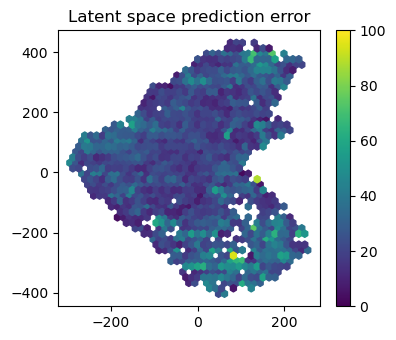

<Figure size 640x480 with 0 Axes>

In [8]:
# Scatter plot with coloring obtained by sum rate per datapoint
latent_space_prediction_errors = true_cc_positions_pred - predicted_cc_positions_pred
latent_space_prediction_errors = np.sqrt(latent_space_prediction_errors[np.argwhere(simplices_le_zero).flatten(),0]**2 + latent_space_prediction_errors[np.argwhere(simplices_le_zero).flatten(),1]**2)

plt.figure(figsize=(4, 3.5))
plt.title('Latent space prediction error')
plt.tight_layout()
vmin = latent_space_prediction_errors.min()
vmax = latent_space_prediction_errors.max()

vmin = 0
vmax = 100

print(vmin)
print(vmax)

plt.hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=latent_space_prediction_errors, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.show()
plt.clf()

## Plot mean sum rate over $N_0$ (best array)

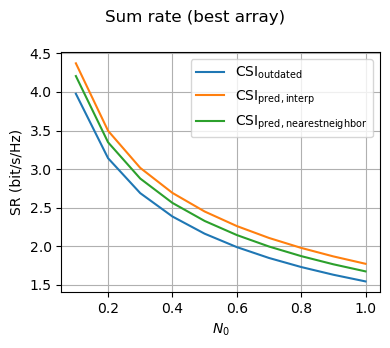

<Figure size 640x480 with 0 Axes>

In [9]:
# noise values for which to compute the sum rate
N_0_vector = np.linspace(0.1,1,10)

# Sum Rate per noise power for Outdated CSI
mean_sum_rate_per_N_0_outdated = []
for i in range(N_0_vector.shape[0]):
    sr = sum_rate(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], outdated_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], N_0  = N_0_vector[i])
    best_array_indices = select_best_array(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], outdated_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()])
    sr_best = []
    for j in range(best_array_indices.shape[0]):
        sr_best.append(sr[j,best_array_indices[j]])
    sr_best = np.asarray(sr_best)
    mean_sum_rate_per_N_0_outdated.append(np.mean(sr_best))
mean_sum_rate_per_N_0_outdated = np.asarray(mean_sum_rate_per_N_0_outdated)

# Sum Rate per noise power for Predicted CSI (Interpolation)
mean_sum_rate_per_N_0_interp = []
for i in range(N_0_vector.shape[0]):
    sr = sum_rate(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], predicted_csi_freq_domain_pred_interp[np.argwhere(simplices_le_zero).flatten()], N_0  = N_0_vector[i])
    best_array_indices = select_best_array(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], predicted_csi_freq_domain_pred_interp[np.argwhere(simplices_le_zero).flatten()])
    sr_best = []
    for j in range(best_array_indices.shape[0]):
        sr_best.append(sr[j,best_array_indices[j]])
    sr_best = np.asarray(sr_best)
    mean_sum_rate_per_N_0_interp.append(np.mean(sr_best))
mean_sum_rate_per_N_0_interp = np.asarray(mean_sum_rate_per_N_0_interp)

# Sum Rate per noise power for Predicted CSI (Nearest Neighbor)
mean_sum_rate_per_N_0_nearest_neighbor = []
for i in range(N_0_vector.shape[0]):
    sr = sum_rate(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], predicted_csi_freq_domain_pred_nearest_neighbor[np.argwhere(simplices_le_zero).flatten()], N_0  = N_0_vector[i])
    best_array_indices = select_best_array(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], predicted_csi_freq_domain_pred_nearest_neighbor[np.argwhere(simplices_le_zero).flatten()])
    sr_best = []
    for j in range(best_array_indices.shape[0]):
        sr_best.append(sr[j,best_array_indices[j]])
    sr_best = np.asarray(sr_best)
    mean_sum_rate_per_N_0_nearest_neighbor.append(np.mean(sr_best))
mean_sum_rate_per_N_0_nearest_neighbor = np.asarray(mean_sum_rate_per_N_0_nearest_neighbor)

fig = plt.subplots(figsize=(4,3.5))
plt.plot(N_0_vector, mean_sum_rate_per_N_0_outdated, label = "$\mathrm{CSI}_\mathrm{outdated}$")
plt.plot(N_0_vector, mean_sum_rate_per_N_0_interp, label = "$\mathrm{CSI}_\mathrm{pred, interp}$")
plt.plot(N_0_vector, mean_sum_rate_per_N_0_nearest_neighbor, label = "$\mathrm{CSI}_\mathrm{pred, nearest neighbor}$")

plt.xlabel("$N_0$")
plt.ylabel("SR (bit/s/Hz)")
plt.legend()
plt.grid()
plt.suptitle("Sum rate (best array)")
plt.tight_layout()
plt.show()
plt.clf()

## Plot sum rate per array

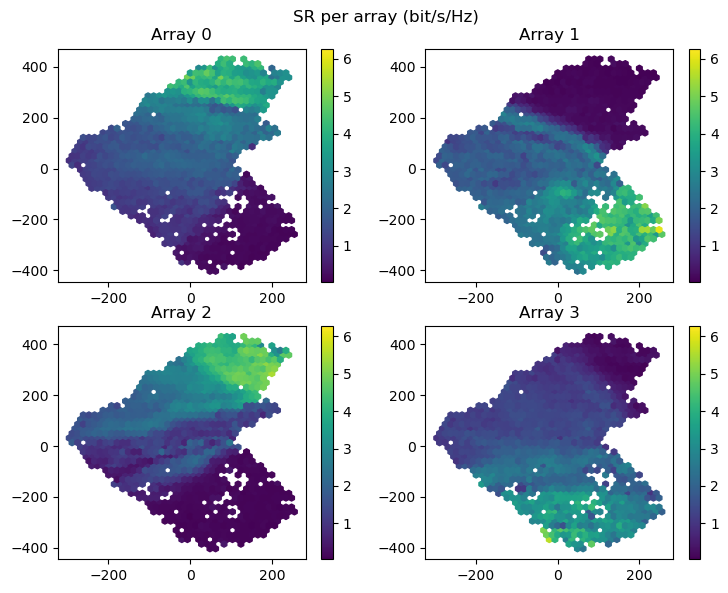

<Figure size 640x480 with 0 Axes>

In [10]:
# Scatter plot with coloring obtained by sum rate per datapoint

sr = sum_rate(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], predicted_csi_freq_domain_pred_interp[np.argwhere(simplices_le_zero).flatten()], N_0 = 0.35)

fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))
fig.suptitle('SR per array (bit/s/Hz)')
fig.tight_layout()
vmin = sr.min()
vmax = sr.max()

# Array 0
axs[0, 0].hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=sr[:, 0], vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Array 0')
fig.colorbar(axs[0, 0].collections[0], ax=axs[0, 0])
# Array 1
axs[0, 1].hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=sr[:, 1], vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Array 1')
fig.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])
# Array 2
axs[1, 0].hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=sr[:, 2], vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Array 2')
fig.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])
# Array 3
axs[1, 1].hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=sr[:, 3], vmin=vmin, vmax=vmax)
axs[1, 1].set_title('Array 3')
fig.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])

plt.show()
plt.clf()

## Plot sum rate at best array

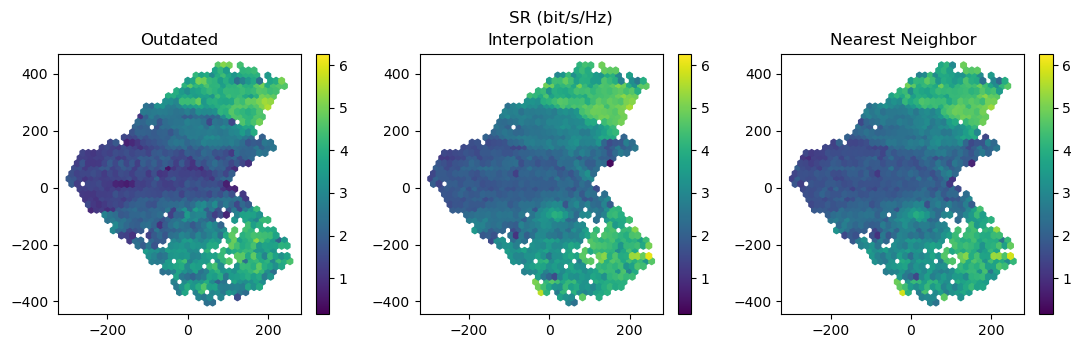

<Figure size 640x480 with 0 Axes>

In [11]:
# Scatter plot with coloring obtained by sum rate per datapoint

# Outdated
sr = sum_rate(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], outdated_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], N_0  = 0.35)

best_array_indices = select_best_array(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], outdated_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()])
sr_best = []
for j in range(best_array_indices.shape[0]):
    sr_best.append(sr[j,best_array_indices[j]])
sr_best_outdated = np.asarray(sr_best)

# Interpolation
sr = sum_rate(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], predicted_csi_freq_domain_pred_interp[np.argwhere(simplices_le_zero).flatten()], N_0 = 0.35)

best_array_indices = select_best_array(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], predicted_csi_freq_domain_pred_interp[np.argwhere(simplices_le_zero).flatten()])
sr_best = []
for j in range(best_array_indices.shape[0]):
    sr_best.append(sr[j,best_array_indices[j]])
sr_best_interp = np.asarray(sr_best)

# Nearest Neighbor
sr = sum_rate(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], predicted_csi_freq_domain_pred_nearest_neighbor[np.argwhere(simplices_le_zero).flatten()], N_0 = 0.35)

best_array_indices = select_best_array(true_csi_freq_domain_pred[np.argwhere(simplices_le_zero).flatten()], predicted_csi_freq_domain_pred_nearest_neighbor[np.argwhere(simplices_le_zero).flatten()])
sr_best = []
for j in range(best_array_indices.shape[0]):
    sr_best.append(sr[j,best_array_indices[j]])
sr_best_nearest_neighbor = np.asarray(sr_best)

vmin = np.array([sr_best_outdated.min(),sr_best_interp.min(),sr_best_nearest_neighbor.min()]).min()
vmax = np.array([sr_best_outdated.max(),sr_best_interp.max(),sr_best_nearest_neighbor.max()]).max()

fig, axs = plt.subplots(1, 3, figsize=(11, 3.5))
fig.suptitle("SR (bit/s/Hz)")
fig.tight_layout()

# Array 0
axs[0].hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=sr_best_outdated, vmin=vmin, vmax=vmax)
axs[0].set_title('Outdated')
fig.colorbar(axs[0].collections[0], ax=axs[0])

# Array 1
axs[1].hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=sr_best_interp, vmin=vmin, vmax=vmax)
axs[1].set_title('Interpolation')
fig.colorbar(axs[1].collections[0], ax=axs[1])

# Array 2
axs[2].hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=sr_best_nearest_neighbor, vmin=vmin, vmax=vmax)
axs[2].set_title('Nearest Neighbor')
fig.colorbar(axs[2].collections[0], ax=axs[2])

plt.show()
plt.clf()

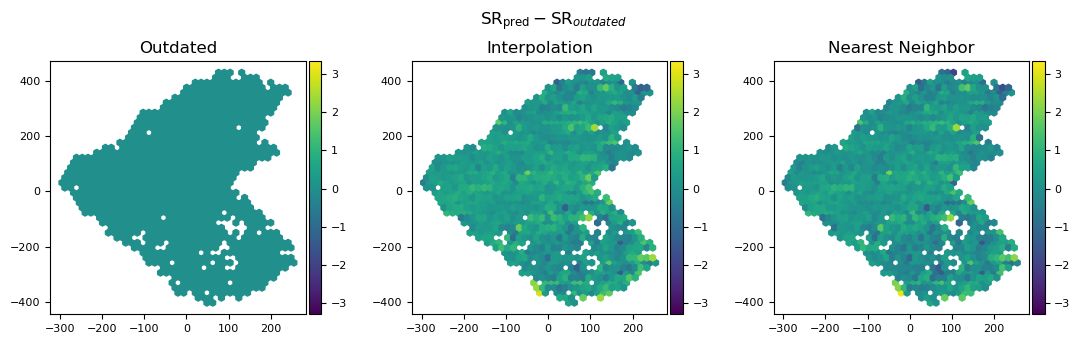

<Figure size 640x480 with 0 Axes>

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3.5))
fig.suptitle('$\mathrm{SR}_\mathrm{pred} - \mathrm{SR}_{outdated}$')
fig.tight_layout()

vmin = np.array([np.subtract(sr_best_interp,sr_best_outdated).min(),np.subtract(sr_best_nearest_neighbor,sr_best_outdated).min()]).min()
vmax = np.array([np.subtract(sr_best_interp,sr_best_outdated).max(),np.subtract(sr_best_nearest_neighbor,sr_best_outdated).max()]).max()

# Array 0
axs[0].hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=sr_best_outdated-sr_best_outdated, vmin=vmin, vmax=vmax)
axs[0].set_title('Outdated')
axs[0].tick_params(axis='both', labelsize=8)
cbar0 = fig.colorbar(axs[0].collections[0], ax=axs[0], pad = 0.01)
cbar0.ax.tick_params(labelsize=8)

# Array 1
axs[1].hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=sr_best_interp-sr_best_outdated, vmin=vmin, vmax=vmax)
axs[1].set_title('Interpolation')
axs[1].tick_params(axis='both', labelsize=8)
cbar1 = fig.colorbar(axs[1].collections[0], ax=axs[1], pad=0.01)
cbar1.ax.tick_params(labelsize=8)

# Array 2
axs[2].hexbin(true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 0],
                  true_cc_positions_pred[np.argwhere(simplices_le_zero).flatten(), 1], 
                  gridsize=40, C=sr_best_nearest_neighbor-sr_best_outdated, vmin=vmin, vmax=vmax)
axs[2].set_title('Nearest Neighbor')
axs[2].tick_params(axis='both', labelsize=8)
cbar2 = fig.colorbar(axs[2].collections[0], ax=axs[2], pad=0.01)
cbar2.ax.tick_params(labelsize=8)

plt.show()
plt.clf()